In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import ast
import wfdb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from typing import List, Dict

from scipy import signal
import wfdb
import wfdb.processing
import ecg_plot

In [3]:
import pathBuilt
from utils import parser, visualization
from utils import features_extraction as fe

In [4]:
raw_data_path = "../data/raw/"

# Preprocessing

In [5]:
df_diagnostic = parser.load_diagnostic(raw_data_path)

In [6]:
df_annotation = parser.load_annotation(df_diagnostic, raw_data_path)

In [7]:
ECG = parser.load_ecg_data(df_annotation, sampling_rate=100, path=raw_data_path)

In [8]:
print("="*50)
print(f"ECG data shape: {ECG.shape}")
print("="*50)
print(f"Annotation data shape: {df_annotation.shape}")
print(f"N. Patients: {df_annotation.patient_id.nunique()}")
print(f"N. Duplicated Patients: {df_annotation[df_annotation.patient_id.duplicated()].patient_id.nunique()}")
print(f"N. ECG Id: {df_annotation.ecg_id.nunique()}")
print(f"ECG Id range: [{df_annotation.ecg_id.min()}, {df_annotation.ecg_id.max()}]")
print(f"Age range: [{df_annotation.age.min()}, {df_annotation.age.max()}]")
print(f"Sex Percentage:\n{df_annotation.sex.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print("="*50)

ECG data shape: (21801, 1000, 12)
Annotation data shape: (21801, 45)
N. Patients: 18869
N. Duplicated Patients: 2113
N. ECG Id: 21801
ECG Id range: [1, 21837]
Age range: [2.0, 300.0]
Sex Percentage:
0    52.1%
1    47.9%
Name: sex, dtype: object


The annotation database contains 18869 patients with 21801 associated 12-leads ECG signals.
The population is spead almost uniformely between man and female.
First, I have decided to clean the annotation db due to the following reasons: ages rages is not realistic, ECG Id is not correct wrt ECG Database.

# Cleaning

In [8]:
df_db = df_annotation.copy()
df_db = parser.clean_df_annotation(df_db)

### Visualization

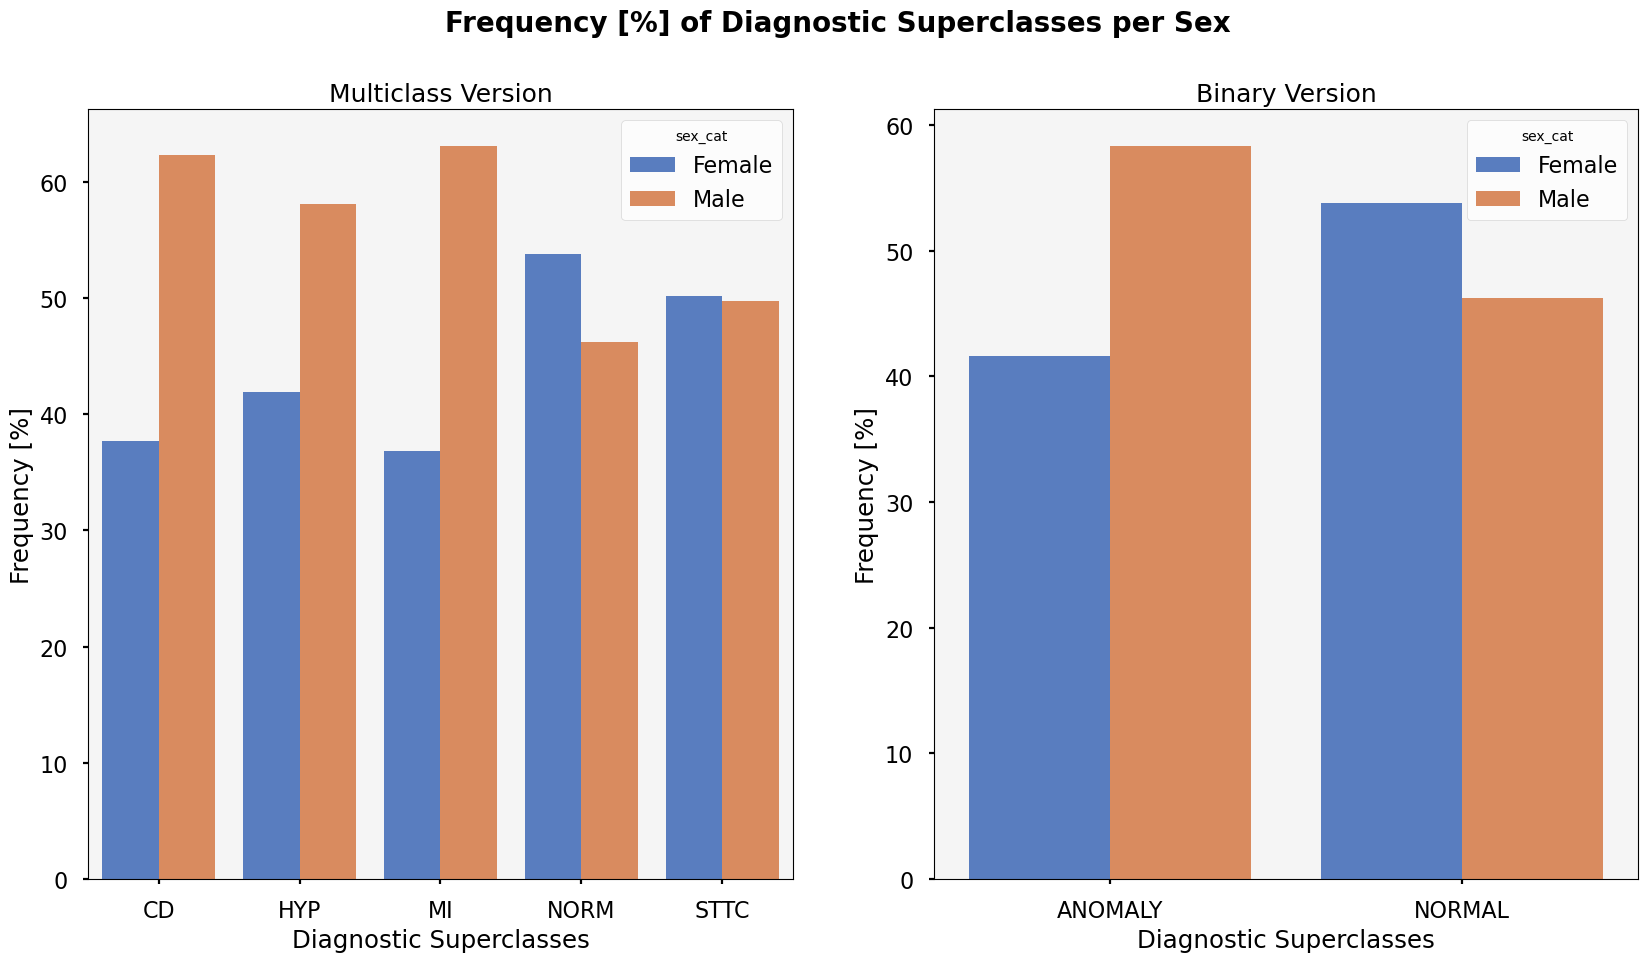

In [13]:
visualization.barplot_cxs(df_db)

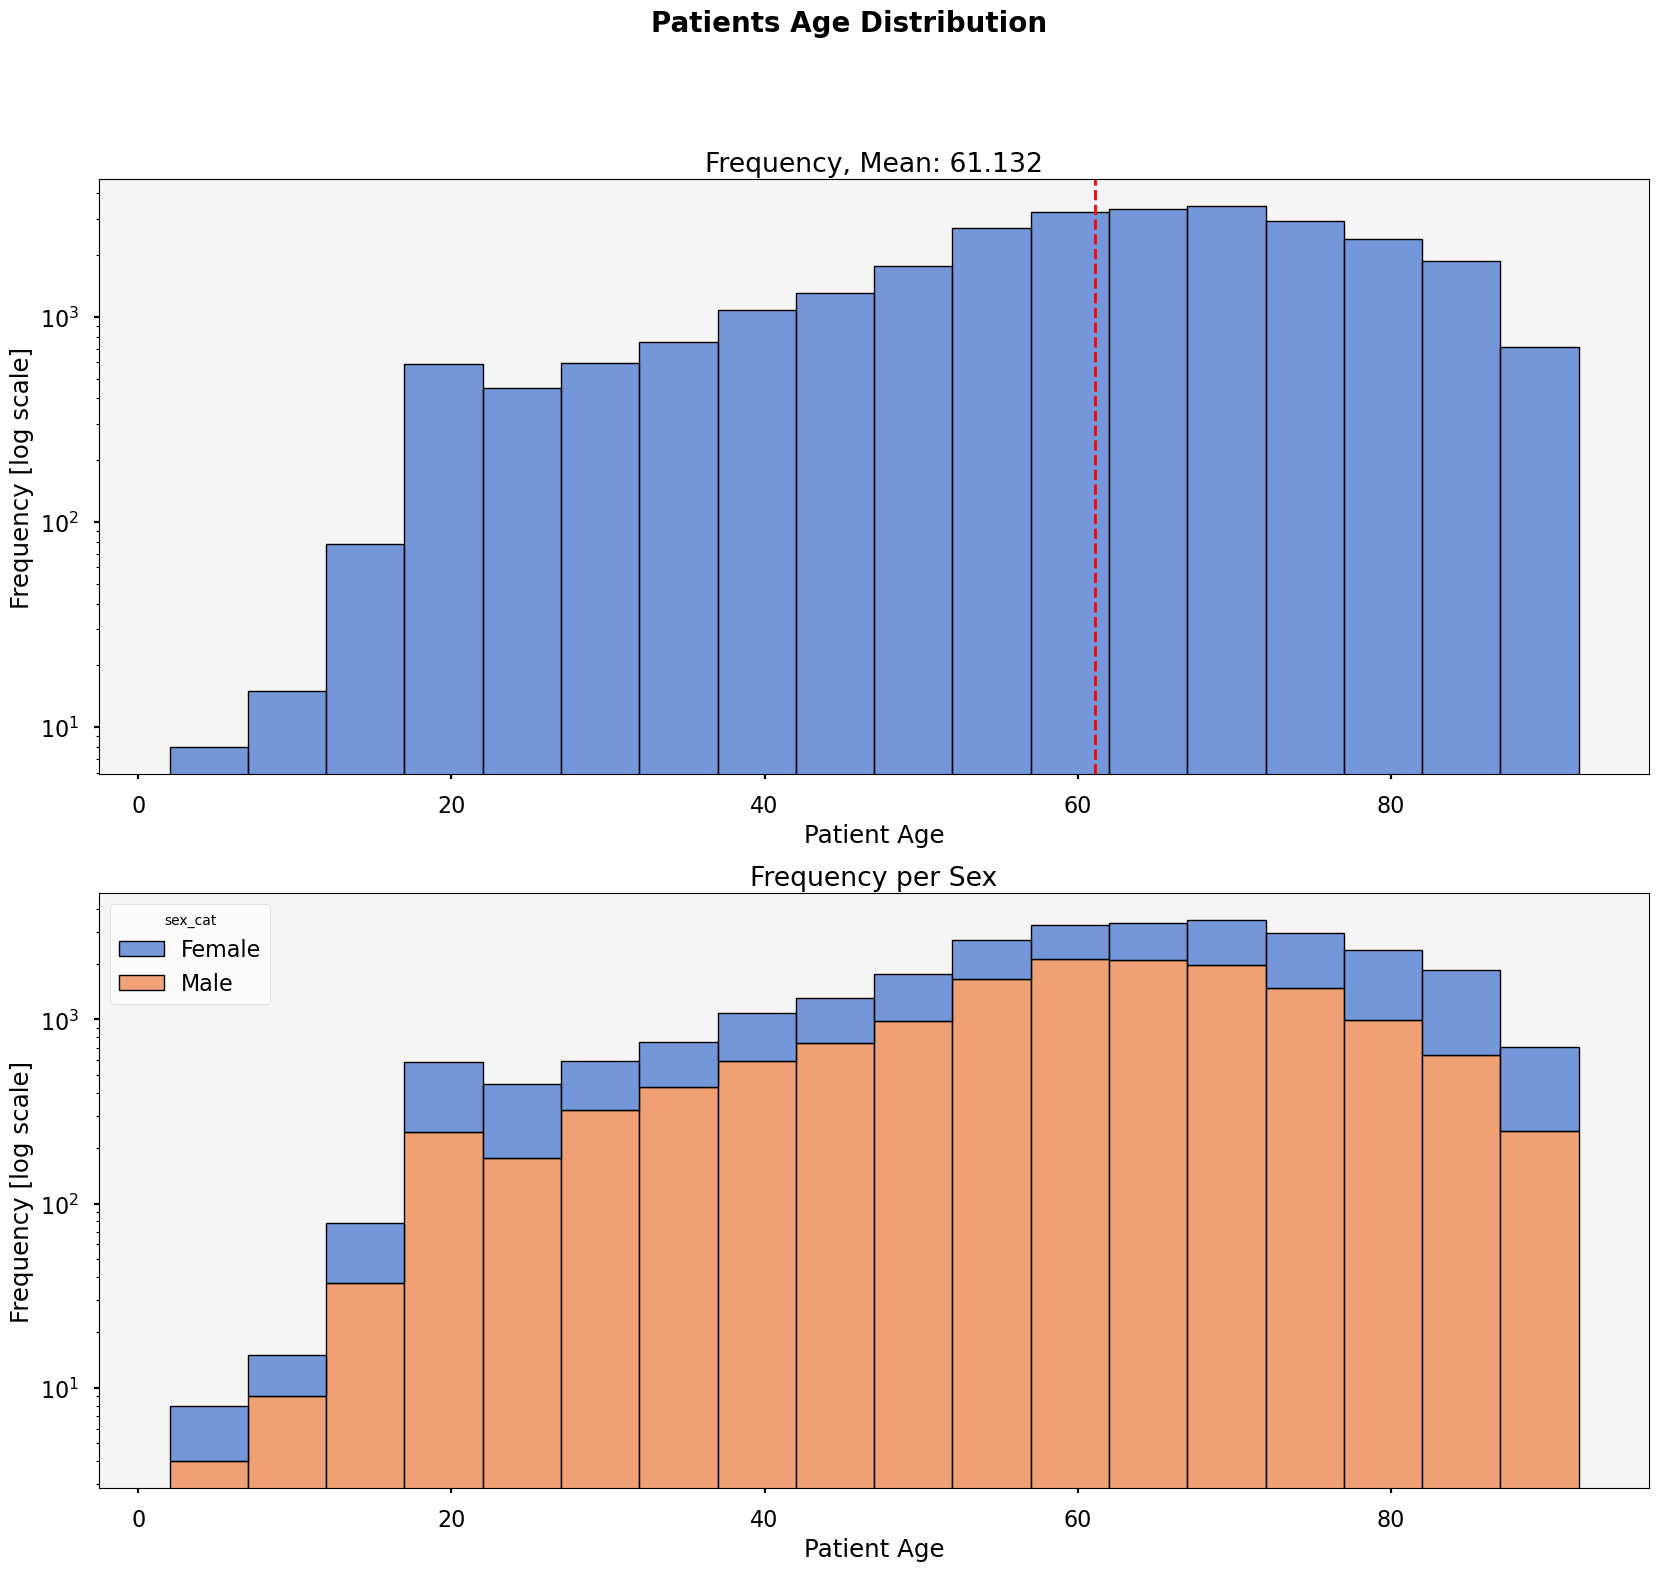

In [14]:
visualization.hist_age(df_db)

I have formatted the annotation db as follows:
- r_peaks column: it contained an object that it wasn't a built-in data types so I turned it into a column of list
- diagnostic_superclass column: it contained blank annotations, so I have decided to drop the indeces associated to them
- age columns: drop the indeces associated to ages greather than 100
- diagnostic_binary_superclass: I have defined a bool column to split the diagnostic superclasses column into a binary categorical column

After the cleaning part, we can see from the plots above the followings:
- there is a tendency to Heart diseases in the male population comparing to the female one
- the ECG anomalies occur more frequently in male than female
- the total population has a mean age of 61
- the female population under study is younger that the male one

# Feature Extraction: detecting ECG components

ECG consists of several main waves, namely, P, Q, R, S and T waves. These waves are generated due to the depolarization of the heart ventricles. QRS complex simply is the combination of the QRS waves. One of the best-known algorithms that is still widely used in commercial devices is due to Pan-Tompkins. Pan-Tompkin's algorithm applies a series of preprocessing steps in order to smooth and amplify the ECG signal and QRS complexs respectively

In what follows, I show some results on ECG components taking into consideration ECG signal with anomalies and not

In [32]:
wf_normal = np.ndarray.flatten(ECG[0,:,0])
rpeaks_wf_n = fe.compute_rpeaks(wf_normal, Fs=100)
time_wf_n = np.arange(wf_normal.shape[0])*1/100
heart_rate_wf_n = fe.compute_heart_rate(ECG[0,:,0], Fs=100)
dist_rpeaks_wf_n = fe.compute_dist_rpeaks(rpeaks_wf_n, wf_normal)

In [33]:
wf_anomaly = np.ndarray.flatten(ECG[0,:,0])
rpeaks_wf_a = fe.compute_rpeaks(wf_anomaly, Fs=100)
time_wf_a = np.arange(wf_anomaly.shape[0])*1/100
heart_rate_wf_a = fe.compute_heart_rate(ECG[0,:,0], Fs=100)
dist_rpeaks_wf_a = fe.compute_dist_rpeaks(rpeaks_wf_a, wf_anomaly)

### Visualization

#### ECG data: Normal ECG

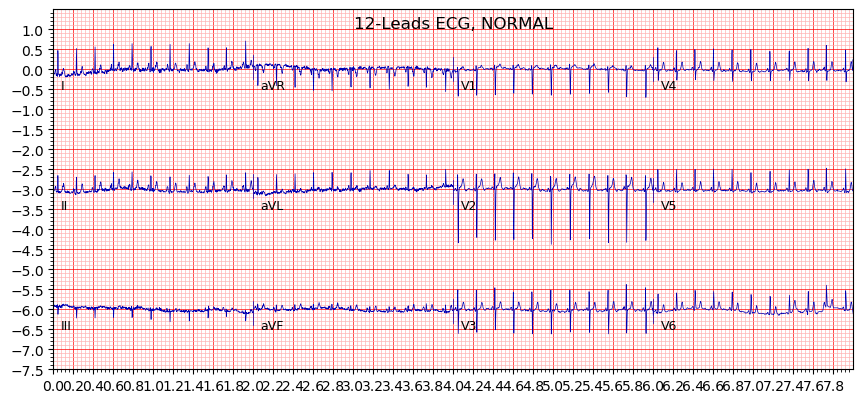

In [34]:
ecg_plot.plot(np.transpose(ECG[0, :, :]), columns=4, title = '12-Leads ECG, NORMAL')
plt.show()

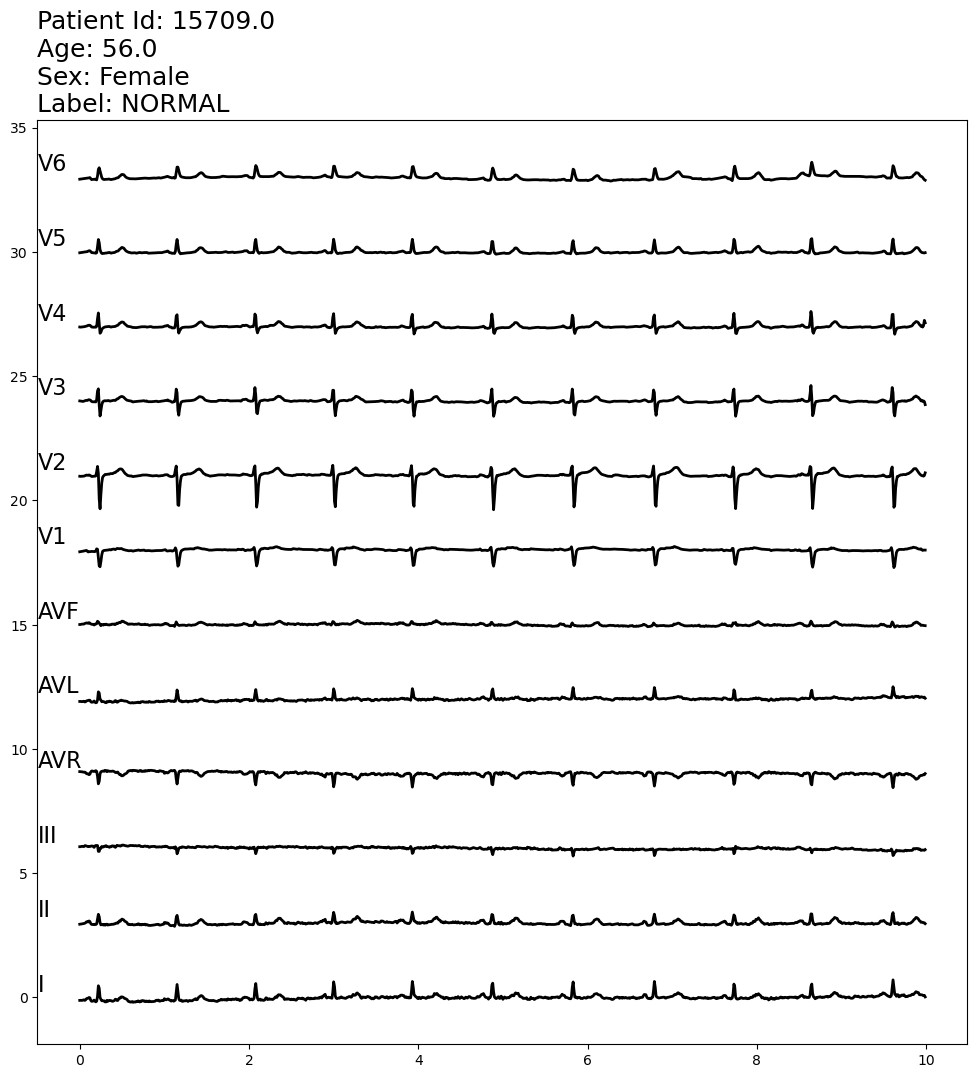

In [37]:
visualization.waveform_plot(0, ECG, df_db, 100)

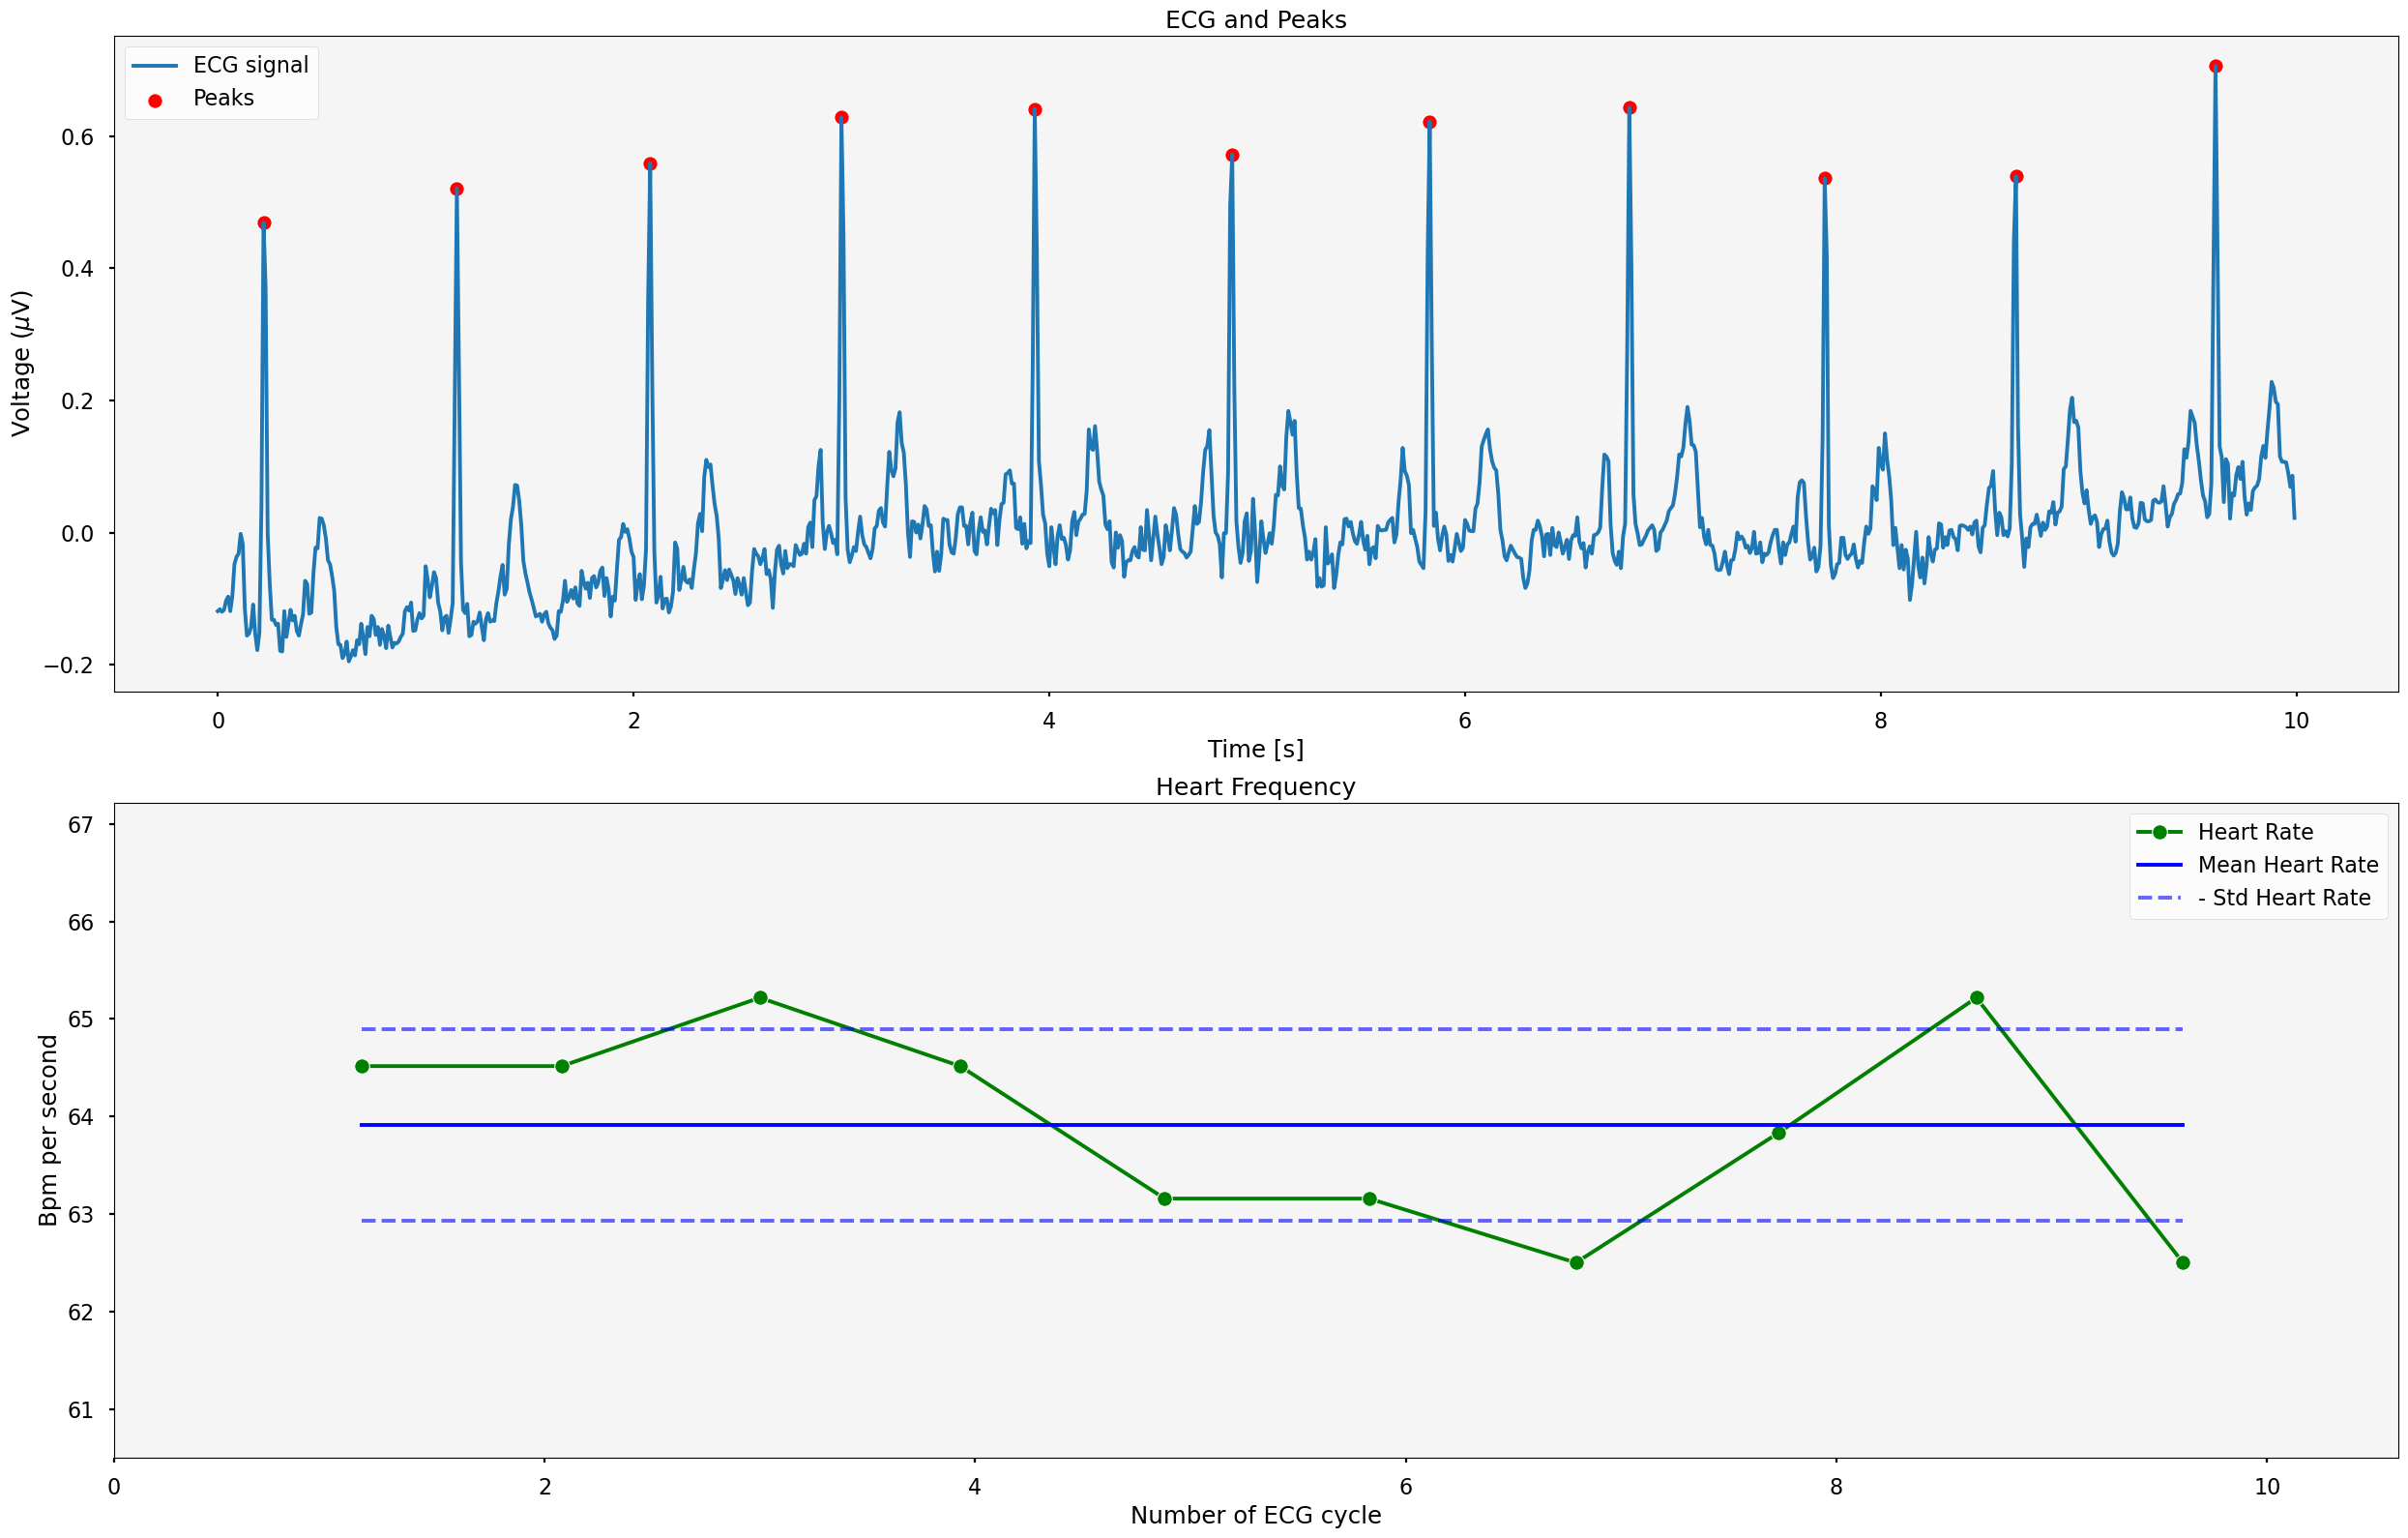

In [38]:
visualization.lineplot_ecg(wf_normal, rpeaks_wf_n, heart_rate_wf_n)

#### ECG data: Anomalous ECG

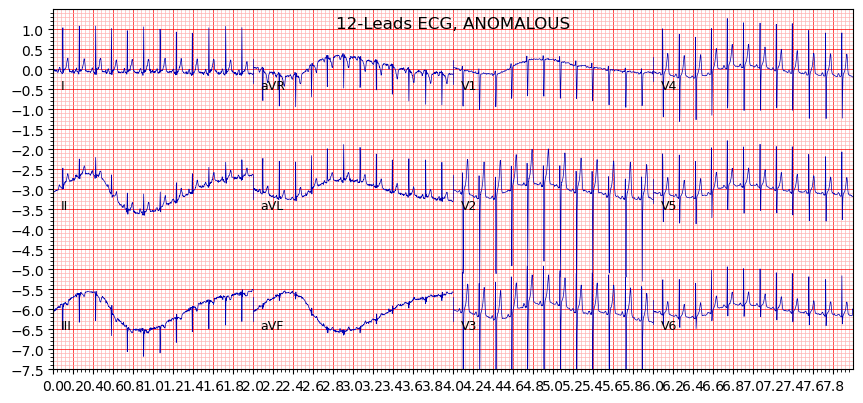

In [39]:
ecg_plot.plot(np.transpose(ECG[7, :, :]), columns=4, title = '12-Leads ECG, ANOMALOUS')
plt.show()

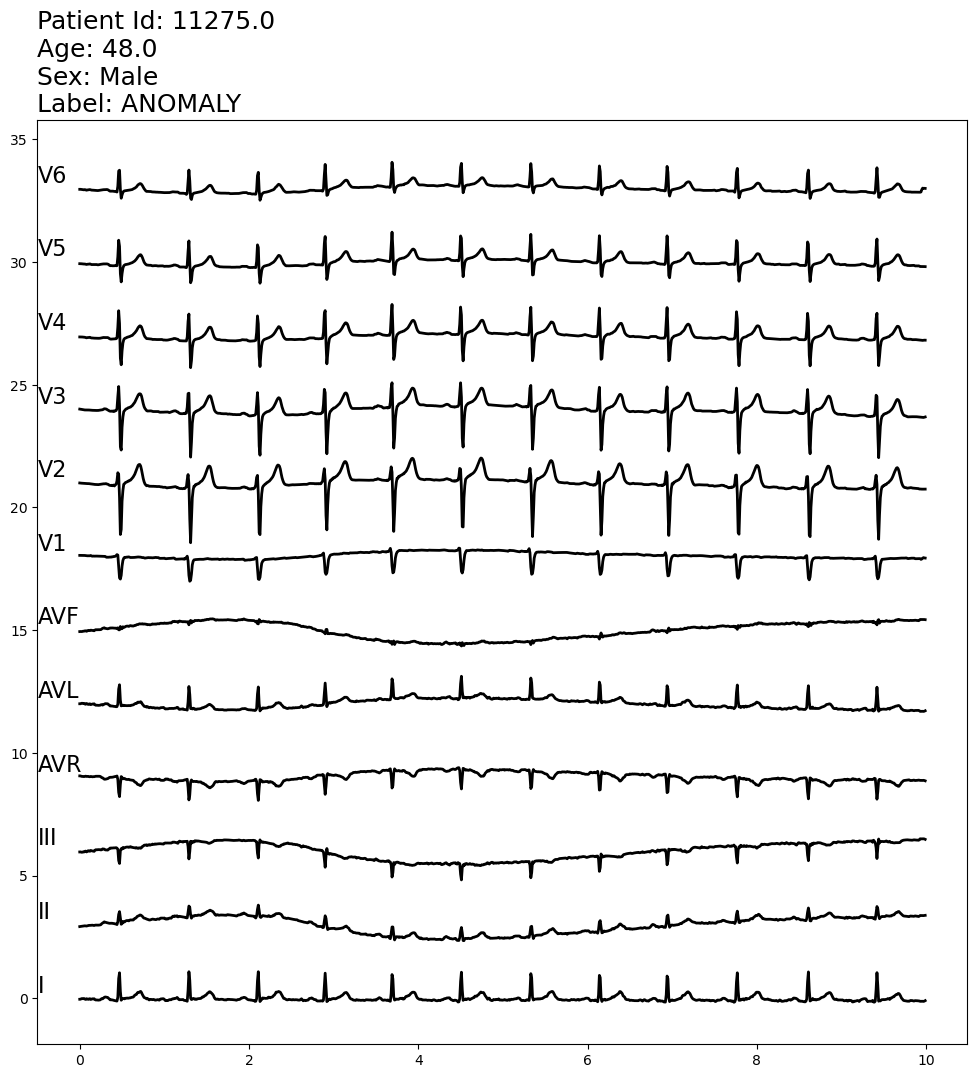

In [40]:
visualization.waveform_plot(7, ECG, df_db, 100)

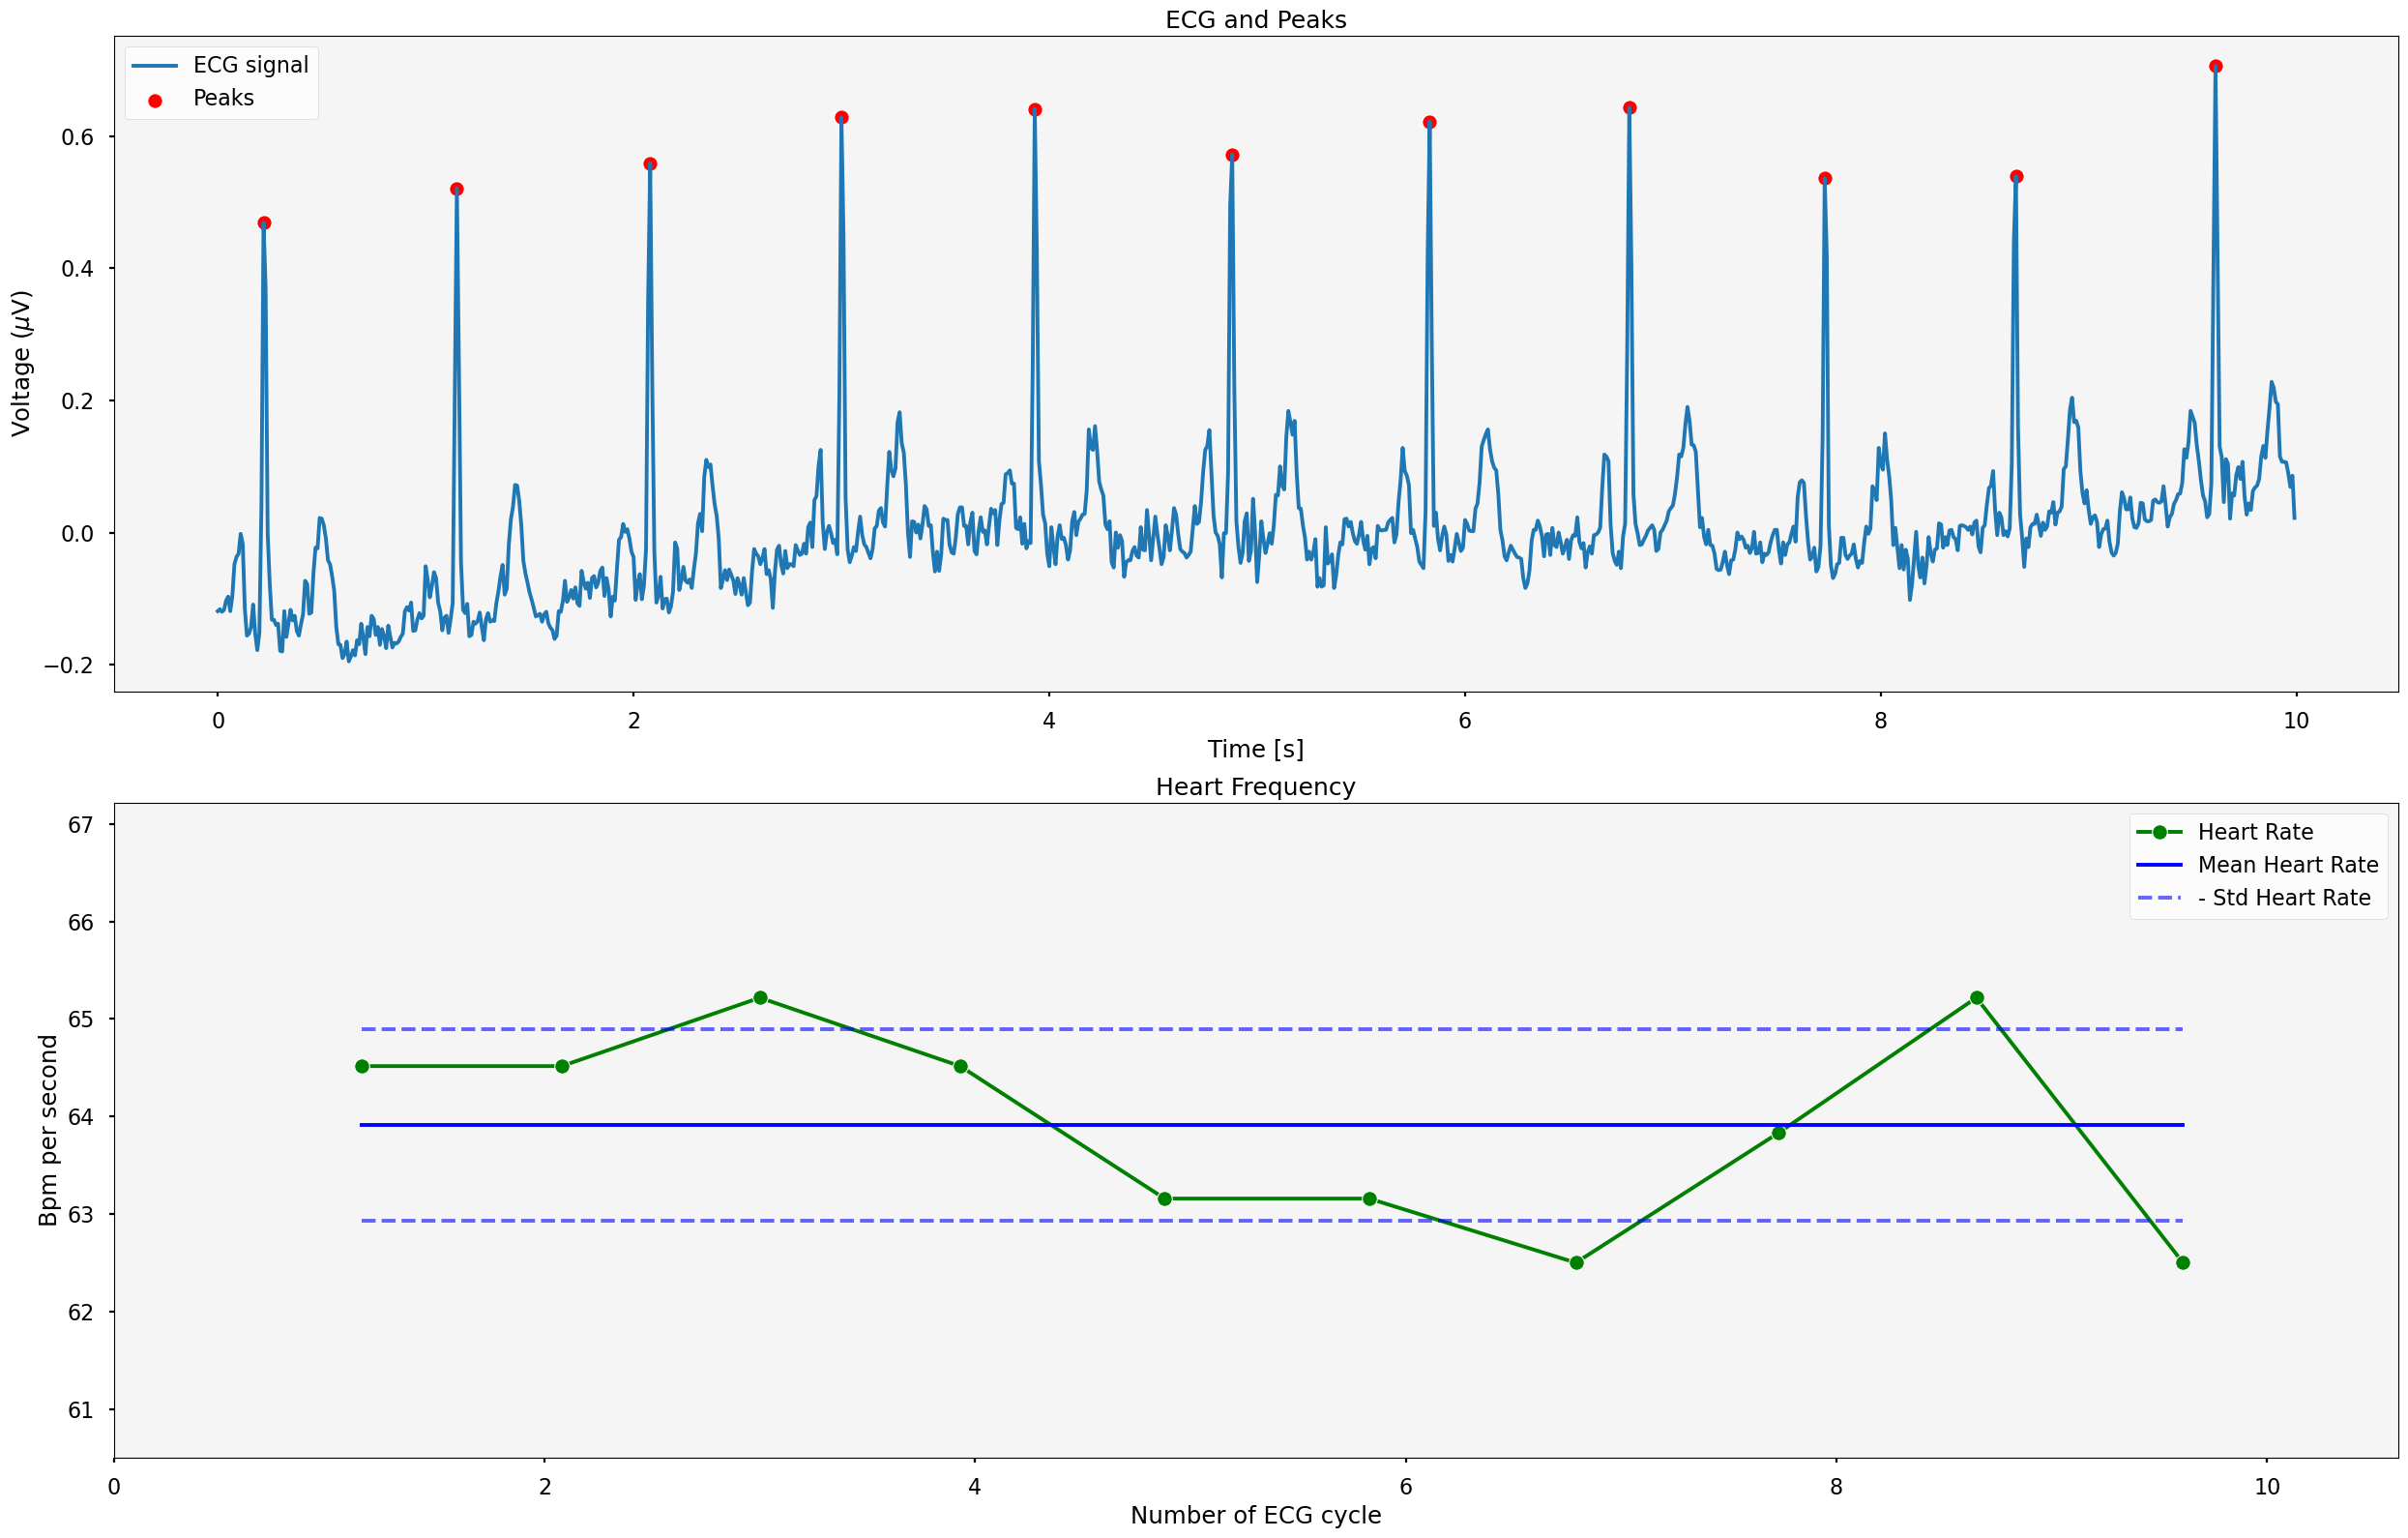

In [42]:
visualization.lineplot_ecg(wf_anomaly, rpeaks_wf_a, heart_rate_wf_a)

# QRS Detection

The Pan-Tompkins algorithm can be broken down in the following steps:

Signal Processing
Bandpass filtering: A bandpass filter is created by a combination of a high pass filter and a low pass filter. The signal is first filtered with a low pass filter and the output of the low pass filter is given to a high pass filter. Here we employ a Butterworth filter. 

Derivative: It is used to get the slope information for the QRS complex. It takes the filtered signal as an input.

Squaring: This just squares all the values in the waveform. 

Moving window integration: It is a kind of running average within a window of certain size

In [46]:
wf_n_bp, wf_n_diff, wf_n_ma,  wf_n_peaks = fe.QRS_peaks(wf_normal, Fs=100)
wf_a_bp, wf_a_diff, wf_a_ma,  wf_a_peaks = fe.QRS_peaks(wf_anomaly, Fs=100)

In [47]:
dist_r_n = fe.compute_dist_rpeaks(wf_n_peaks, wf_normal)
dist_r_a = fe.compute_dist_rpeaks(wf_a_peaks, wf_anomaly)

ECG Normal

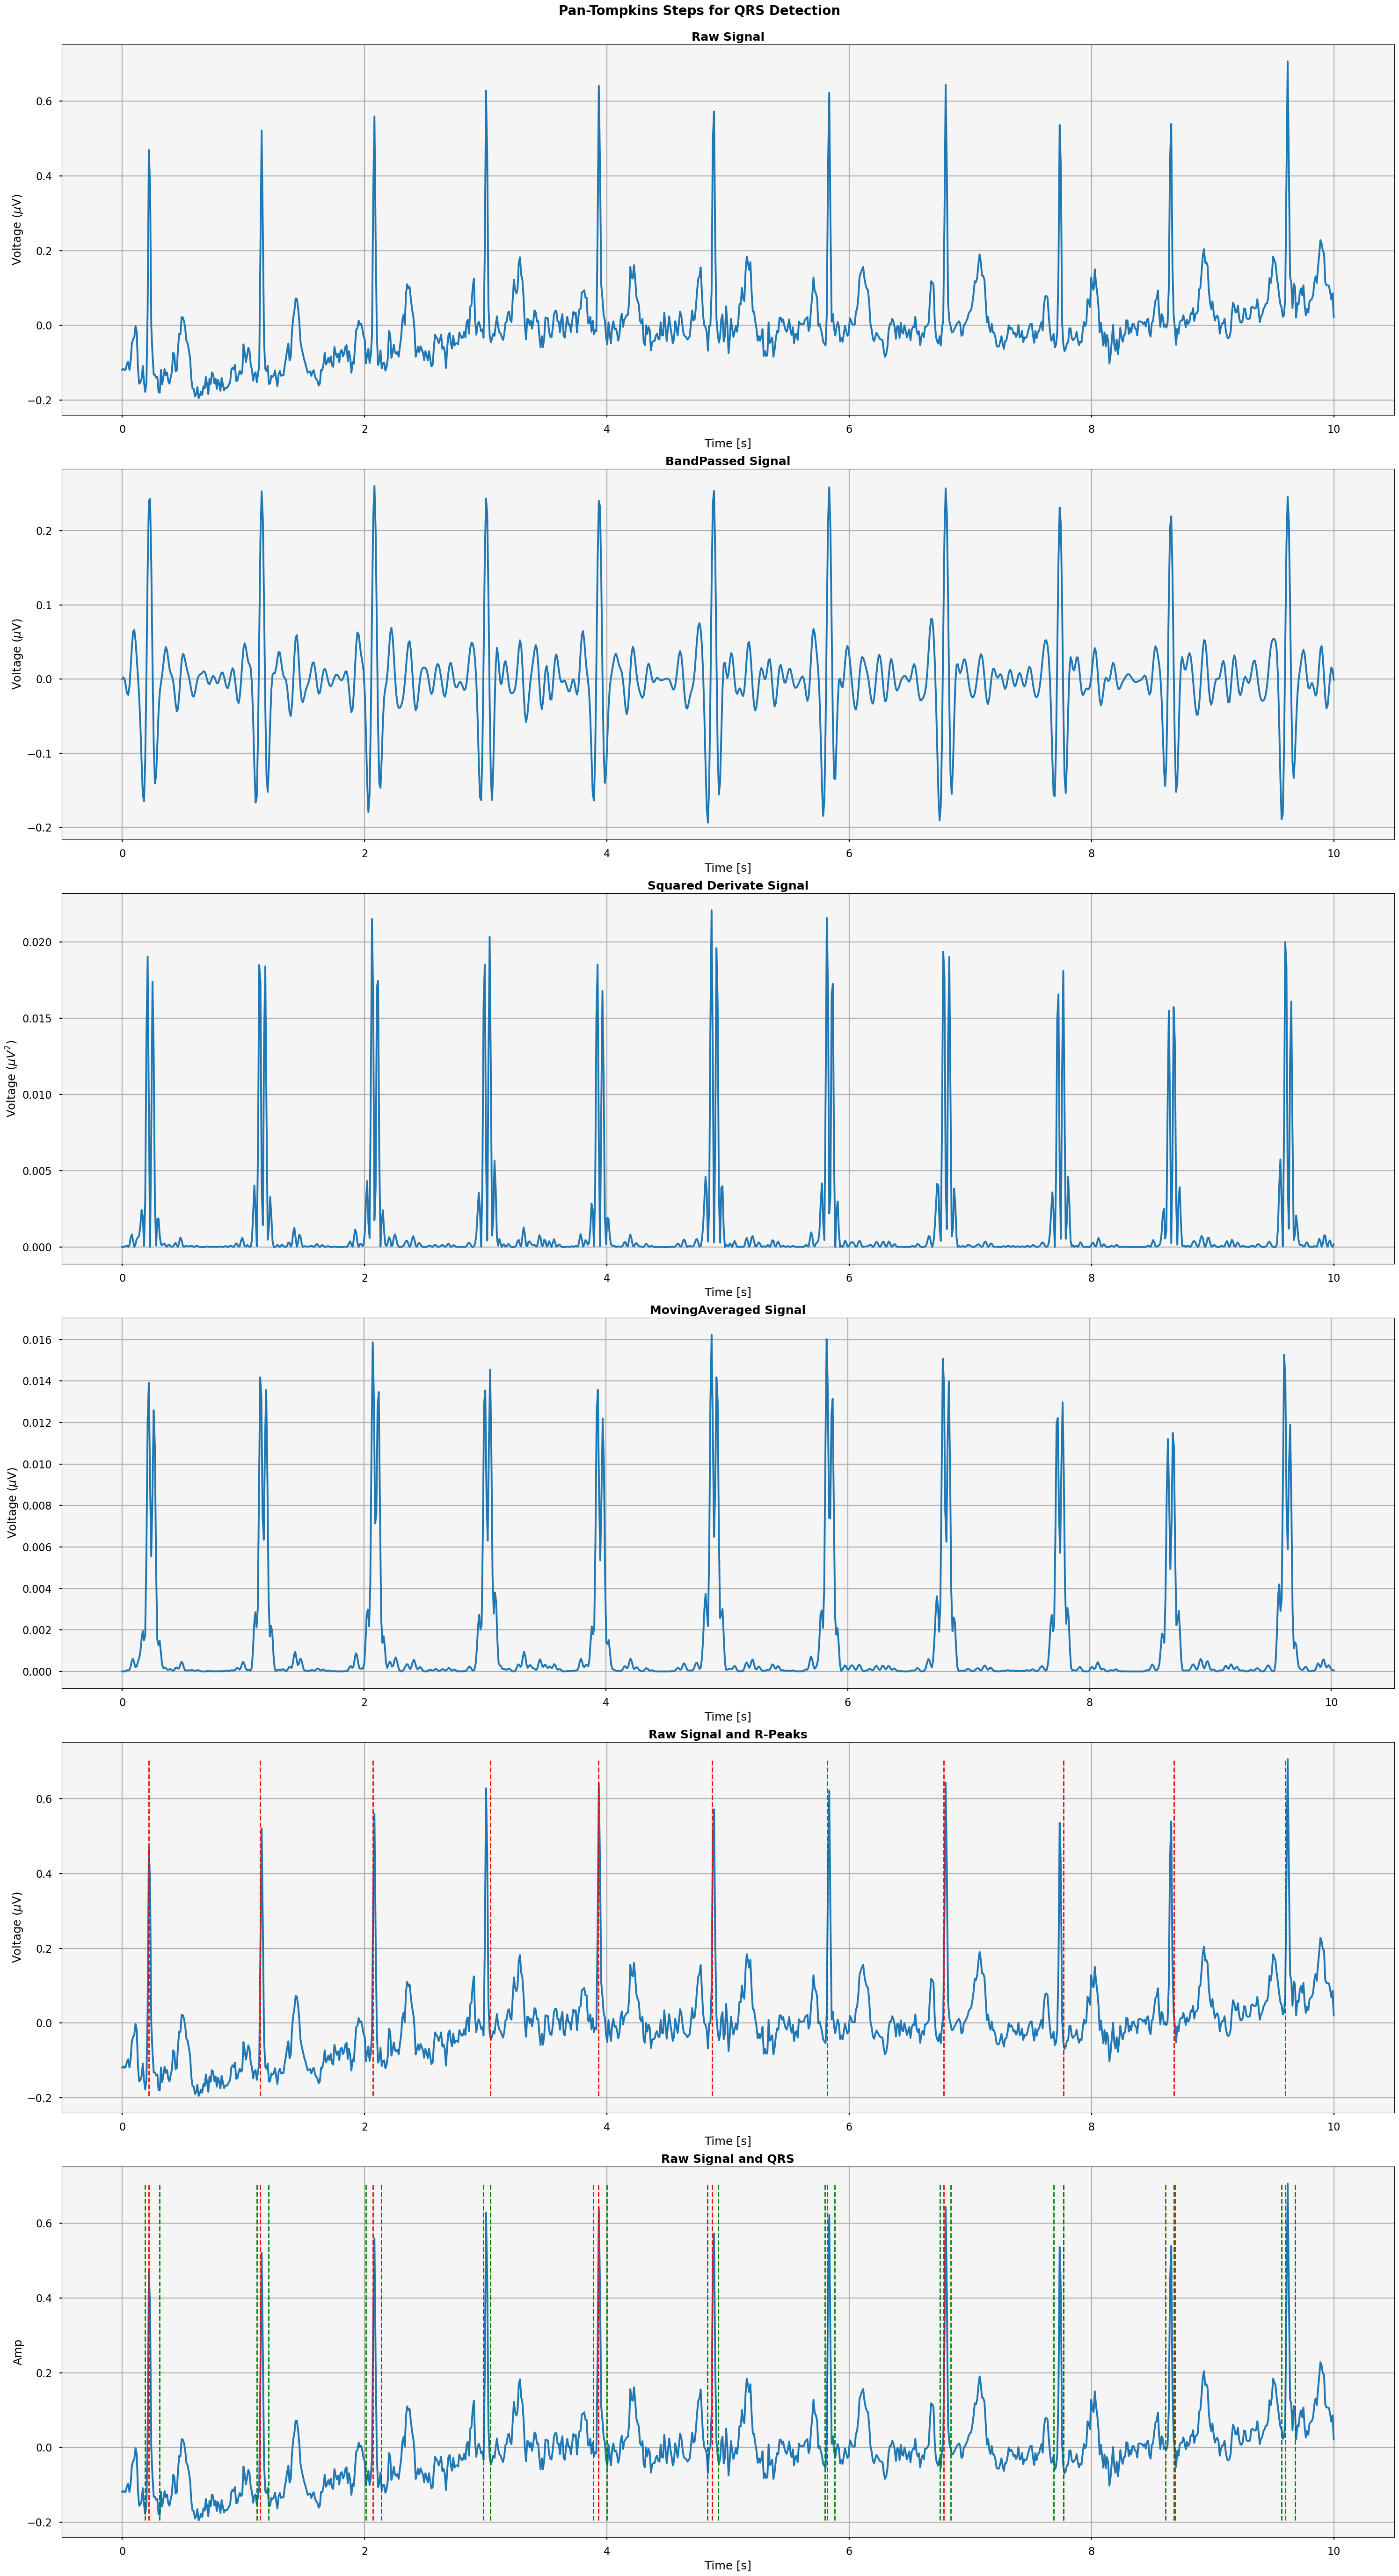

In [55]:
visualization.QRS_detection_plot(wf_normal,wf_n_bp, wf_n_diff, wf_n_ma,  wf_n_peaks,dist_r_n, Fs=100)

ECG with anomalies

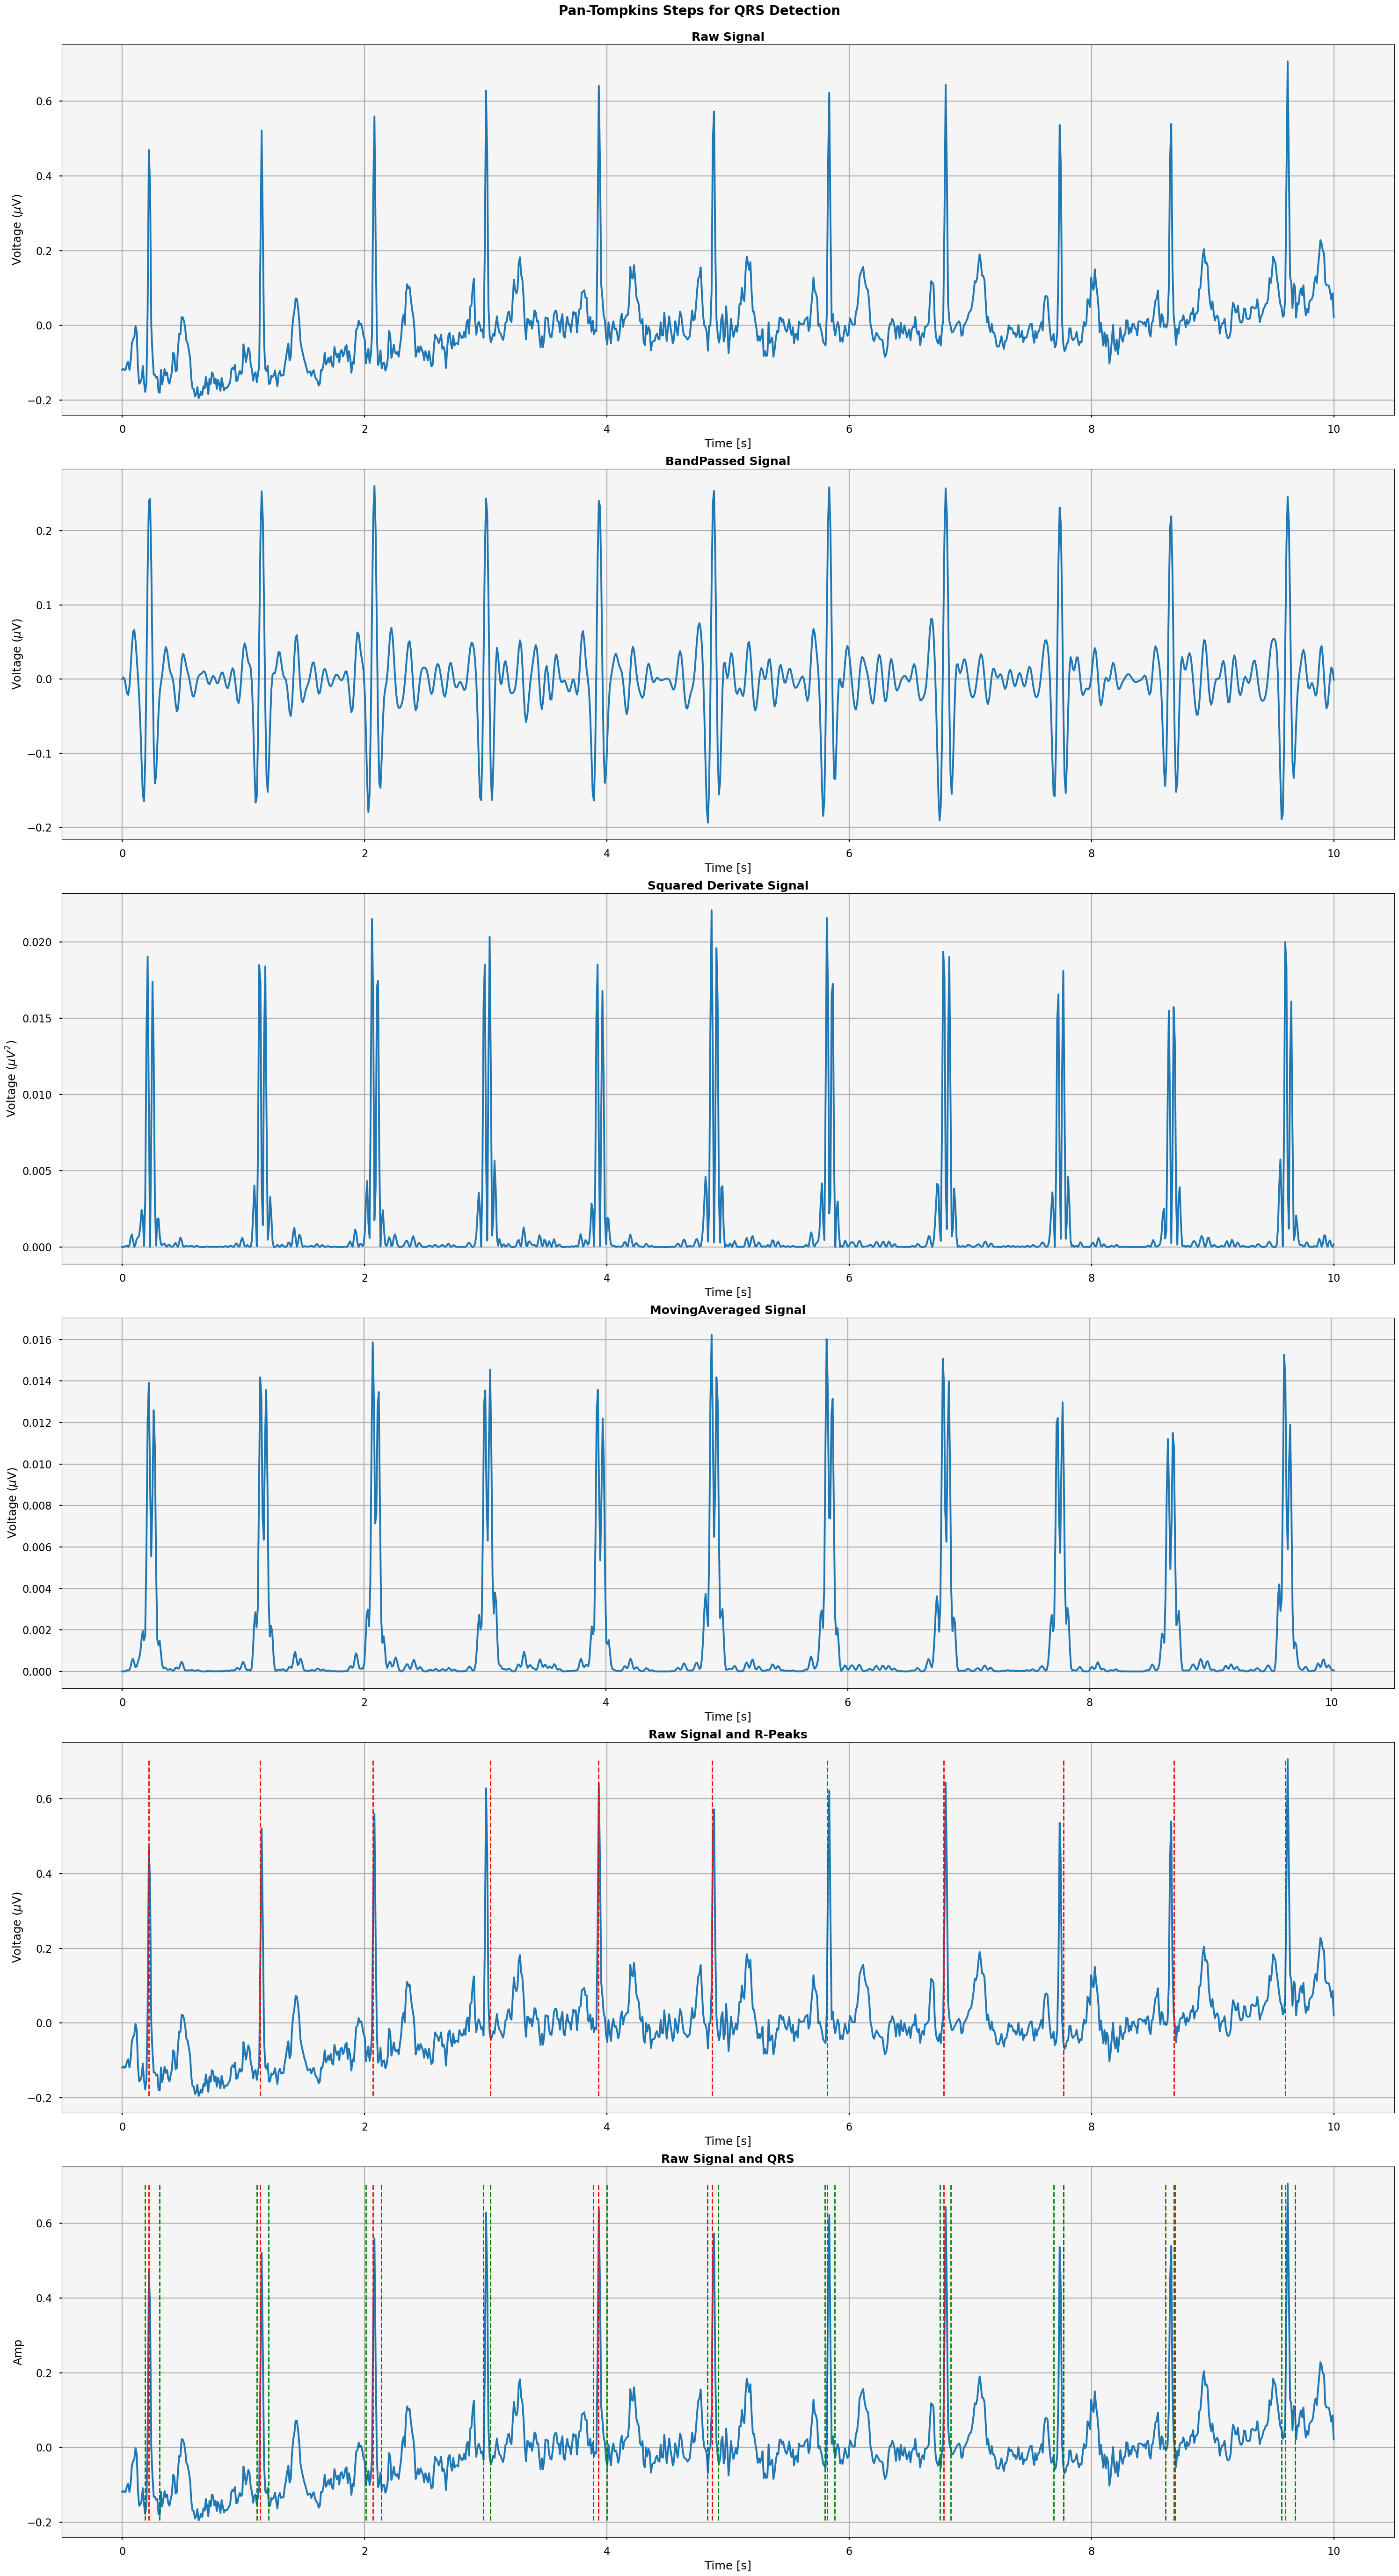

In [56]:
visualization.QRS_detection_plot(wf_anomaly,wf_a_bp, wf_a_diff, wf_a_ma, 
                                 wf_a_peaks,dist_r_a, Fs=100)

# Simple Model

In [21]:
from keras.layers import Dense, Input, Dropout
from keras.models import  Sequential


from sklearn.metrics import confusion_matrix

In [13]:
df_db["diagn_binary_class"] = df_db.diagnostic_binary_superclass.map({"ANOMALY":1, "NORMAL":0})

In [11]:
ECG_2 = ECG[df_db.index,:,:]

In [15]:
test_fold = 10
# Train
X_train = ECG_2[np.where(df_db.strat_fold != test_fold)]
y_train = df_db[(df_db.strat_fold != test_fold)].diagn_binary_class
# Test
X_test = ECG_2[np.where(df_db.strat_fold == test_fold)]
y_test = df_db[df_db.strat_fold == test_fold].diagn_binary_class

In [23]:
y_test.value_counts()

1    1776
0     963
Name: diagn_binary_class, dtype: int64

In [16]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [17]:
history = model.fit(X_train, y_train, batch_size = 32, epochs= 100, verbose = 1)

Epoch 1/100
768/768 [==============================] - 31s 36ms/step - loss: 0.6325 - accuracy: 0.6524
Epoch 2/100
768/768 [==============================] - 28s 36ms/step - loss: 0.6222 - accuracy: 0.6537
Epoch 3/100
768/768 [==============================] - 26s 34ms/step - loss: 0.6197 - accuracy: 0.6552
Epoch 4/100
768/768 [==============================] - 25s 33ms/step - loss: 0.6183 - accuracy: 0.6559
Epoch 5/100
768/768 [==============================] - 24s 31ms/step - loss: 0.6173 - accuracy: 0.6565
Epoch 6/100
768/768 [==============================] - 24s 31ms/step - loss: 0.6167 - accuracy: 0.6570
Epoch 7/100
768/768 [==============================] - 24s 31ms/step - loss: 0.6161 - accuracy: 0.6580
Epoch 8/100
768/768 [==============================] - 24s 31ms/step - loss: 0.6158 - accuracy: 0.6584
Epoch 9/100
768/768 [==============================] - 23s 30ms/step - loss: 0.6154 - accuracy: 0.6588
Epoch 10/100
768/768 [==============================] - 23s 29ms/step - l

In [18]:
y_pred = model.predict(X_test)

86/86 [==============================] - 8s 7ms/step


In [24]:
scores = model.evaluate((X_test),y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 66.18%
